In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
import collections
import nest_asyncio
#%reload_ext tensorboard
nest_asyncio.apply()
from adahessian import AdaHessian

In [2]:
# Neural network model in pytorch defined here
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
#        self.conv1 = nn.Conv2d(1, 20, 5, 1)
#        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(784, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = torch.from_numpy(np.array(x))
#        x = F.relu(self.conv1(x))
#        x = F.max_pool2d(x, 2, 2)
#        x = F.relu(self.conv2(x))
#        x = F.max_pool2d(x, 2, 2)
#        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
#        m = nn.LogSoftmax(dim = 1)
        return x

In [3]:
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data(only_digits=True)

In [4]:
class server:
    
    def __init__(self, numOfClients):
        self.numOfClients = numOfClients #Num of Client
        self.clientIds = list(range(0,self.numOfClients)) #Client List
        self.updateRoundNum = 0  # Update Round Number
        self.serverModel = self.createBaseModel() #Create a Keras Model for MNIST
        self.clientActive = [] #If client is available or not based on time - day/night
        self.clientCIF = []
        self.updateFromClients=[]
        self.__serverTestData_X=[]
        self.__serverTestData_Y=[]
        self.__serverTestData= self.setServerTestDataTFF(emnist_test)
        self.predictionAcc=[]
        self.predictionLoss=[]
        
        
    def createBaseModel(self):
        return Net()
    
    def setServerTestData(self,Xtest,Ytest):  # NOT USED IN THIS CASE
        self.__serverTestData_X=Xtest
        self.__serverTestData_Y=Ytest
        
    def setServerTestDataTFF(self,serverTestData):  #Creates a test set for server
        
        BATCH_SIZE = 100
        SHUFFLE_BUFFER = 100
        PREFETCH_BUFFER= 10

        def preprocess(dataset):
            def batch_format_fn(element):
        #        Flatten a batch `pixels` and return the features as an `OrderedDict`.
                return collections.OrderedDict(
                    x=tf.reshape(element['pixels'], [-1, 784]),
                    y=tf.reshape(element['label'], [-1, 1]))

            return dataset.repeat(10).shuffle(SHUFFLE_BUFFER).batch(
              BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)

        serverData = tfds.as_numpy(preprocess(serverTestData.create_tf_dataset_for_client(serverTestData.client_ids[30])))
        

        return serverData

    
    def initialBroadcast(self):
        for i in self.clientIds:
            clientName = "client_"+str(self.clientIds[i])  #Create Client Name
            #print(clientName)
            eval(clientName).setInitialModel(self.serverModel) #setInitialModel-> Method of client Class
            
    def getClientActiveStatus(self):  #if the client is available for update or not randomly set in client
        self.clientActive = []
        for i in self.clientIds:
            clientName = "client_"+str(self.clientIds[i])  #Create Client Name
            #print(clientName)
            if(eval(clientName).sendActiveStatus() == 1): #getActiveStatus() -> method of client class
                self.clientActive.append(i)
        
            
    def getClientCIF(self): # Get Client Importance Factor for active clients
        self.clientCIF=[]
        for i in self.clientActive:
            clientName = "client_"+str(i)
            c_cif = eval(clientName).sendCIF()   #sendCIF() - method of client
            self.clientCIF.append(c_cif)
        #print("Clients with Acceptable CIF: ", self.clientCIF)
    
    def getModelUpdateFromClients(self):
        print("--------------------------------------------\n","Round NO:",self.updateRoundNum)
        print("Active Clients: ",self.clientActive)
        print("CIF of Active Clients: ", self.clientCIF)
        print("Training Clients with CIF > 10")
        self.updateRoundNum +=1
        self.updateFromClients=[]
        #self.dataPointsClients=[]
        for i in range (0,len(self.clientActive)):
            if self.clientCIF[i] >= 10:  #Select Client only if CIF > some value 10 chosen for testing ONLY
                clientName = "client_"+str(int(self.clientActive[i]))
                self.updateFromClients.append(eval(clientName).sendClientUpdate()) #Get a list of updates from selected clients
                #print(updateFromClients)
        
        avgModelWeights = self.computeFedAvg(self.updateFromClients)
        #print("average model weights = \n",avgModelWeights)
        #self.serverModel.set_weights(avgModelWeights)   
        

        
        new_state_dict = {}
        model_counter = 0
        # handle the conv layers part which is not changing
        for param_idx, (key_name, param) in enumerate(self.serverModel.state_dict().items()):
        #print("&"*30)
        #print("Key: {}, Weight Shape: {}, Matched weight shape: {}".format(key_name, param.size(), weights[param_idx].shape))
        #print("&"*30)
            if "conv" in key_name or "features" in key_name:
                if "weight" in key_name:
                    temp_dict = {key_name: avgModelWeights[param_idx].reshape(param.size())}
                elif "bias" in key_name:
                    temp_dict = {key_name: avgModelWeights[param_idx]}
            elif "fc" in key_name or "classifier" in key_name:
                if "weight" in key_name:
                    temp_dict = {key_name: avgModelWeights[param_idx]}
                elif "bias" in key_name:
                    temp_dict = {key_name: avgModelWeights[param_idx]}

            new_state_dict.update(temp_dict)
            
            
        self.serverModel.load_state_dict(new_state_dict)


            
    
        
    def computeFedAvg(self,updates):#Compute Federated Averaging from Available Clients
        with torch.no_grad():
            
            totalDataPoints = 0
            scaleFactor=[]
            for i in range (0,len(updates)):
                totalDataPoints += updates[i][1]   #Sum the total Data Points on All Available Clients
                scaleFactor.append(updates[i][1])  #Store individual number datapoints for client
        
        
            scaleFactor = np.array(scaleFactor)/totalDataPoints #Create the scale factor
        
            sumOfAvgWeights = []*len(updates[0][0]) 
        
            for j in range (0,len(updates[0][0])): #range of layers
                k=torch.zeros_like(updates[0][0][j])
                for i in range(0,len(updates)): #range of clients
                    k=k+updates[i][0][j]*scaleFactor[i]
                #print("ShapeofK:",k.shape)
                sumOfAvgWeights.append(k)
        
        
            return sumOfAvgWeights   
    
    def testServerModel(self):
        testData = next(iter(self.__serverTestData))

        output = self.serverModel(testData['x'])
        testData['y'] = torch.LongTensor(testData['y'])
        target = torch.max(testData['y'], 1)[0]
        loss = F.cross_entropy(output, target)
        pred = output.data.max(1, keepdim=True)[1]
        correct = pred.eq(testData['y'].view_as(pred)).sum().item()
        accuracy = 100*correct/len(testData['y'])
        print('\nLength of the test data: ',len(testData['y']))
        print("Loss: ",loss)
        print("Accuracy: ",accuracy)
        return loss, accuracy
      
    def updateAllClients(self):
        
        updatedWeights = []
        for param in self.serverModel.parameters():
            updatedWeights.append(param)
       
        for i in self.clientIds:
            clientName = "client_"+str(self.clientIds[i])  #Create Client Name
        
            eval(clientName).setModelUpdateWeights(updatedWeights) 



In [5]:
class client:
    
    def __init__(self,ID):
        self.id = ID
        self.__clientModel = Net()
        self.__clientModelWeights=[]
        self.activeStatus = 0
        self.__clientDataX=[] #Private to Client
        self.__clientDataY=[]
        self.clientCIF=0
        self.SNR = 0
        self.epochs = 10
        self.lr = 0.01
        self.__clientData = self.__clientDataFromTFF(emnist_train)
    
    
    #Methods Private to client
    
    def __clientDataFromTFF(self,tffDataset):
        NUM_EPOCHS = self.epochs
        BATCH_SIZE = 100
        SHUFFLE_BUFFER = 100
        PREFETCH_BUFFER= 10

        def preprocess(dataset):
            def batch_format_fn(element):
                """Flatten a batch `pixels` and return the features as an `OrderedDict`."""
                return collections.OrderedDict(
                    x=tf.reshape(element['pixels'], [-1, 784]),
                    y=tf.reshape(element['label'], [-1, 1]))

            return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER).batch(
              BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)
        
        return tfds.as_numpy(preprocess(tffDataset.create_tf_dataset_for_client(tffDataset.client_ids[self.id])))
        
    
    def __setActiveStatus(self): 
        self.activeStatus = int(np.random.randint(0,2,1))
        #self.activeStatus = 1
    
    def __setCIF(self):
        self.clientCIF = int(np.random.randint(0,50,1))  # Random Number between 0 and 49 for vheck purpose only
        #self.clientCIF = 20
        
    def __getTrainData(self):
        return self.__clientDataX, self.__clientDataY  # Just for Testing will be expanded to select meaningful data
    
    #Public Methods
    def sendActiveStatus(self):
        self.__setActiveStatus()
        return self.activeStatus
    
    def sendCIF(self):
        self.__setCIF()
        return self.clientCIF
    
    def setInitialModel(self,model):
        self.__clientModel=model
         
    def setClientData(self,X,Y):
        self.__clientDataX = X
        self.__clientDataY = Y
   

    def sendClientUpdate(self):
        print("->",self.id,end=" ")
       # optimizer = optim.SGD(self.__clientModel.parameters(), lr = self.lr)
        optimizer = AdaHessian(self.__clientModel.parameters(), lr = self.lr)
        #print(self.__clientDataX.shape)
        #print(self.__clientDataY.shape)
        if len(self.__clientDataX) > 0:
            numOfDataPoints = len(self.__clientDataX)
   #         self.__clientDataX = self.__clientDataX.to(device)
   #         self.__clientDataY = self.__clientDataY.to(device)
            for epoch in range(self.epochs):
                optimizer.zero_grad()
                output = self.__clientModel(self.__clientDataX)
                loss = F.cross_entropy(output, torch.max(self.__clientDataY, 1)[0])
                loss.backward(create_graph=True)
                optimizer.step()
        
        else:
            currentData = next(iter(self.__clientData))
   #         currentData = currentData.to(device)
            numOfDataPoints = len(currentData['x'])
            for epoch in range(self.epochs):
                optimizer.zero_grad()
                output = self.__clientModel(currentData['x'])
                currentData['y'] = torch.LongTensor(currentData['y'])
                loss = F.cross_entropy(output, torch.max(currentData['y'], 1)[0])
                loss.backward(create_graph=True)
                optimizer.step()

            
        updatedWeights = []
        for param in self.__clientModel.parameters():
            updatedWeights.append(param)
       
      
        return (updatedWeights,numOfDataPoints)
    
    def setModelUpdateWeights(self,modelUpdateWeights):
        new_state_dict = {}
        model_counter = 0
        # handle the conv layers part which is not changing
        for param_idx, (key_name, param) in enumerate(self.__clientModel.state_dict().items()):
        #print("&"*30)
        #print("Key: {}, Weight Shape: {}, Matched weight shape: {}".format(key_name, param.size(), weights[param_idx].shape))
        #print("&"*30)
            if "conv" in key_name or "features" in key_name:
                if "weight" in key_name:
                    temp_dict = {key_name: modelUpdateWeights[param_idx].reshape(param.size())}
                elif "bias" in key_name:
                    temp_dict = {key_name: modelUpdateWeights[param_idx]}
            elif "fc" in key_name or "classifier" in key_name:
                if "weight" in key_name:
                    temp_dict = {key_name: modelUpdateWeights[param_idx]}
                elif "bias" in key_name:
                    temp_dict = {key_name: modelUpdateWeights[param_idx]}

            new_state_dict.update(temp_dict)
            
            
        self.__clientModel.load_state_dict(new_state_dict)


        
    def plotClientData(self):
        print("Y_Data",self.__clientDataY)
        id0=[]
        id1=[]
        id2=[]
        id3=[]
        id4=[]
        id5=[]
        id6=[]
        id7=[]
        id8=[]
        id9=[]
        for i in range (0,len(self.__clientData['x'])):
            for j in range (0,10):
                if j==self.__clientData['y']:
                    eval('id'+str(j)).append(i)
        xAxis=['0','1','2','3','4','5','6','7','8','9']
        yAxis=[len(id0),len(id1),len(id2),len(id3),len(id4),len(id5),len(id6),len(id7),len(id8),len(id9)]
        plt.bar(xAxis,yAxis)
        title="Data for Client"+str(self.id)
        plt.title(title)
        plt.show()

## Initializing Clients

In [6]:
#Populate Clients
N = 100

client_0=client(0)
client_1=client(1)
client_2=client(2)
client_3=client(3)
client_4=client(4)
client_5=client(5)
client_6=client(6)
client_7=client(7)
client_8=client(8)
client_9=client(9)
client_10=client(10)
client_11=client(11)
client_12=client(12)
client_13=client(13)
client_14=client(14)
client_15=client(15)
client_16=client(16)
client_17=client(17)
client_18=client(18)
client_19=client(19)
client_20=client(20)
client_21=client(21)
client_22=client(22)
client_23=client(23)
client_24=client(24)
client_25=client(25)
client_26=client(26)
client_27=client(27)
client_28=client(28)
client_29=client(29)
client_30=client(30)
client_31=client(31)
client_32=client(32)
client_33=client(33)
client_34=client(34)
client_35=client(35)
client_36=client(36)
client_37=client(37)
client_38=client(38)
client_39=client(39)
client_40=client(40)
client_41=client(41)
client_42=client(42)
client_43=client(43)
client_44=client(44)
client_45=client(45)
client_46=client(46)
client_47=client(47)
client_48=client(48)
client_49=client(49)
client_50=client(50)
client_51=client(51)
client_52=client(52)
client_53=client(53)
client_54=client(54)
client_55=client(55)
client_56=client(56)
client_57=client(57)
client_58=client(58)
client_59=client(59)
client_60=client(60)
client_61=client(61)
client_62=client(62)
client_63=client(63)
client_64=client(64)
client_65=client(65)
client_66=client(66)
client_67=client(67)
client_68=client(68)
client_69=client(69)
client_70=client(70)
client_71=client(71)
client_72=client(72)
client_73=client(73)
client_74=client(74)
client_75=client(75)
client_76=client(76)
client_77=client(77)
client_78=client(78)
client_79=client(79)
client_80=client(80)
client_81=client(81)
client_82=client(82)
client_83=client(83)
client_84=client(84)
client_85=client(85)
client_86=client(86)
client_87=client(87)
client_88=client(88)
client_89=client(89)
client_90=client(90)
client_91=client(91)
client_92=client(92)
client_93=client(93)
client_94=client(94)
client_95=client(95)
client_96=client(96)
client_97=client(97)
client_98=client(98)
client_99=client(99)


### Initializing Sever

In [7]:

serverFA = server(N)   # N = Number of Client


In [8]:
serverFA.initialBroadcast()

In [9]:
numberOfTraingRounds = 20
trainingMetrics=[]*numberOfTraingRounds
for i in range(0,numberOfTraingRounds):
    serverFA.getClientActiveStatus()
    serverFA.getClientCIF()
    serverFA.getModelUpdateFromClients()
    trainingMetrics.append(serverFA.testServerModel())
    serverFA.updateAllClients()


--------------------------------------------
 Round NO: 0
Active Clients:  [0, 2, 3, 8, 9, 10, 13, 15, 16, 17, 18, 19, 21, 22, 25, 26, 31, 35, 36, 37, 39, 40, 41, 42, 45, 49, 51, 55, 56, 61, 63, 66, 69, 72, 74, 75, 76, 79, 80, 82, 85, 87, 88, 89, 90, 91, 92, 93, 94, 97, 98]
CIF of Active Clients:  [1, 32, 33, 15, 13, 43, 35, 9, 11, 3, 30, 19, 41, 41, 36, 49, 46, 47, 27, 5, 3, 8, 12, 9, 4, 22, 45, 31, 28, 3, 47, 11, 4, 27, 47, 28, 13, 45, 24, 28, 4, 15, 43, 36, 24, 1, 30, 4, 5, 19, 24]
Training Clients with CIF > 10
-> 2 -> 3 -> 8 -> 9 -> 10 -> 13 -> 16 -> 18 -> 19 -> 21 -> 22 -> 25 -> 26 -> 31 -> 35 -> 36 -> 41 -> 49 -> 51 -> 55 -> 56 -> 63 -> 66 -> 72 -> 74 -> 75 -> 76 -> 79 -> 80 -> 82 -> 87 -> 88 -> 89 -> 90 -> 92 -> 97 -> 98 
Length of the test data:  100
Loss:  tensor(2.1106, grad_fn=<NllLossBackward>)
Accuracy:  24.0
--------------------------------------------
 Round NO: 1
Active Clients:  [0, 2, 6, 8, 10, 12, 14, 15, 16, 17, 18, 19, 23, 25, 26, 29, 31, 38, 39, 40, 42, 44, 48, 4

-> 1 -> 2 -> 5 -> 8 -> 10 -> 11 -> 12 -> 14 -> 16 -> 21 -> 22 -> 23 -> 24 -> 25 -> 27 -> 28 -> 29 -> 31 -> 38 -> 39 -> 40 -> 42 -> 43 -> 46 -> 48 -> 49 -> 50 -> 51 -> 52 -> 55 -> 63 -> 66 -> 69 -> 72 -> 74 -> 75 -> 77 -> 80 -> 85 -> 86 -> 89 -> 92 -> 93 -> 94 
Length of the test data:  100
Loss:  tensor(1.4865, grad_fn=<NllLossBackward>)
Accuracy:  67.0
--------------------------------------------
 Round NO: 11
Active Clients:  [0, 2, 9, 11, 13, 15, 16, 18, 20, 23, 28, 29, 30, 31, 33, 35, 36, 39, 42, 44, 45, 46, 47, 48, 52, 54, 60, 62, 64, 65, 68, 70, 71, 74, 75, 76, 79, 81, 82, 89, 93, 94, 96, 99]
CIF of Active Clients:  [34, 43, 48, 2, 42, 22, 27, 30, 42, 39, 46, 46, 9, 47, 31, 5, 16, 30, 22, 17, 30, 48, 5, 43, 47, 26, 41, 41, 20, 12, 12, 16, 37, 41, 2, 31, 22, 8, 13, 47, 13, 10, 45, 8]
Training Clients with CIF > 10
-> 0 -> 2 -> 9 -> 13 -> 15 -> 16 -> 18 -> 20 -> 23 -> 28 -> 29 -> 31 -> 33 -> 36 -> 39 -> 42 -> 44 -> 45 -> 46 -> 48 -> 52 -> 54 -> 60 -> 62 -> 64 -> 65 -> 68 -> 70 -> 7

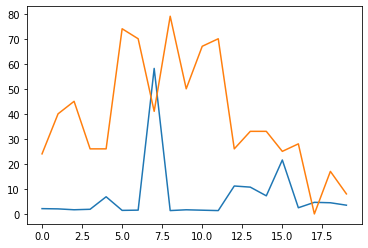

In [10]:
plt.plot(trainingMetrics)

### Below are Rough cells ... donot run

### --> SNR - Get Value the Channel Importance - Transmit Power, Additional Gaussian Noice, Channel Rayliegh Fading (hk) 

### -->Data Augmentation at Every Round
: Client 0 - 6000 Data, For first round - 3000 - specifying the epochs, batch_size =32 (Default) model.fit()
3400 - Calculate the Entropy - CIF along with the SNR- Importance of the update Training - additional 400 data
4000

### --> Code Benchmarking use EMNIST dataset and check the code w.r.t TFF solution <- 20TH NOV

### --> Check on the leaf dataset - LSTM , CNN, 

### --> Second order optimizer - implement using adahessian < change the model pytorch

### --> comparisons with Just SNR, SNR with Data importance, with and without adahessian, 

### --> check for convergence vs number of users

### --> How will the code perform if the model changed to CNN